### Imports & GPU Selection

In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
import os
import gc
import re

# SPECIFY GPU
device = torch.device("mps")

/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# BERT Fine-Tuned On PolitiFact (Human)

In [2]:
# Function to create tokenised text attention masks & labels in tensor format
def pre_process_data(data, tokenizer, max_len):
    text = data['text']
    labels = data['is_true']

    untruncated_tokenised_sequences = [(tokenizer.encode(text, truncation=False, add_special_tokens=True)) for text in text]

    tokenised_sequences = tokenizer.batch_encode_plus(
    text.tolist(),
    max_length = max_len,
    pad_to_max_length=True,
    truncation=True)

    tokenised_sequence_tensor = torch.tensor(tokenised_sequences['input_ids'])
    mask_tensor = torch.tensor(tokenised_sequences['attention_mask'])
    labels_tensor = torch.tensor(labels.tolist())

    return untruncated_tokenised_sequences, tokenised_sequence_tensor, mask_tensor, labels_tensor

In [3]:
# Define tokeniser & truncation max length
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
max_len = 256

# Load data
train_df = pd.read_csv("/Applications/AI/msc_project/data/my_politifact_train.csv")
val_df = pd.read_csv("/Applications/AI/msc_project/data/my_politifact_validation.csv")

# Obtain tokenised text, attention masks & labels in tensor format
train_untruncated_seq, train_seq, train_mask, train_y = pre_process_data(train_df, tokenizer, max_len)
val_untruncated_seq, val_seq, val_mask, val_y = pre_process_data(val_df, tokenizer, max_len)

/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (5466 > 512). Running this sequence through the model will result in indexing errors
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific len

## Define Model Architecture

In [4]:
# Define frozen BERT model
def initialise_bert_model():
    # Load original BERT and freeze its parameters
    bert = AutoModel.from_pretrained('bert-base-uncased')
    for param in bert.parameters():
        param.requires_grad = False

    # Define the model architecture with classification head
    # Classification head: ReLu -> FC -> ReLu -> FC -> Softmax
    class BERT_Arch(nn.Module):

        # Define layers within the model (we use these layers in the forward pass)
        def __init__(self, bert):
            super(BERT_Arch, self).__init__()
            self.bert = bert
            self.dropout = nn.Dropout(0.1)
            self.relu = nn.ReLU()
            self.fc1 = nn.Linear(768, 512)
            self.fc2 = nn.Linear(512, 2)
            self.softmax = nn.LogSoftmax(dim=1)

        # Define forward pass (flow of data) through network
        def forward(self, sent_id, mask):
            # Pass the CLS token (BERT's output) to the model
            _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
            x = self.fc1(cls_hs)
            x = self.relu(x)
            x = self.dropout(x)
            x = self.fc2(x)
            x = self.softmax(x)
            return x

    # Create an instance of BERT and place on GPU
    model = BERT_Arch(bert)
    model = model.to(device)

    return model

In [5]:
# Define unfrozen BERT model
def initialise_bert_model_unfrozen():
    # Load original BERT and freeze its parameters
    bert = AutoModel.from_pretrained('bert-base-uncased')
    for param in bert.parameters():
        param.requires_grad = True

    # Define the model architecture with classification head
    # Classification head: ReLu -> FC -> ReLu -> FC -> Softmax
    class BERT_Arch(nn.Module):

        # Define layers within the model (we use these layers in the forward pass)
        def __init__(self, bert):
            super(BERT_Arch, self).__init__()
            self.bert = bert
            self.dropout = nn.Dropout(0.1)
            self.relu = nn.ReLU()
            self.fc1 = nn.Linear(768, 512)
            self.fc2 = nn.Linear(512, 2)
            self.softmax = nn.LogSoftmax(dim=1)

        # Define forward pass (flow of data) through network
        def forward(self, sent_id, mask):
            # Pass the CLS token (BERT's output) to the model
            _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
            x = self.fc1(cls_hs)
            x = self.relu(x)
            x = self.dropout(x)
            x = self.fc2(x)
            x = self.softmax(x)
            return x

    # Create an instance of BERT and place on GPU
    model = BERT_Arch(bert)
    model = model.to(device)

    return model

## Define Training & Evaluation Processes

In [6]:
# Define training function for BERT model
def train(loss_function, optimizer, train_dataloader,model):
    model.train()
    total_loss = 0
    total_preds = []
    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        batch_loss = loss_function(preds, labels)
        total_loss += batch_loss.item()
        batch_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

# Define evaluation function for BERT model
def evaluate(loss_function, val_dataloader,model):
    print("\nEvaluating...")
    model.eval()
    total_loss = 0
    total_preds = []
    for step, batch in enumerate(val_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        with torch.no_grad():
            preds = model(sent_id, mask)
            batch_loss = loss_function(preds, labels)
            total_loss += batch_loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

## Get Learning Curve

In [8]:
# Function to perform training and validation with predefined hyperparameters and plot learning curves
def train_and_evaluate_with_steps(model_init, lr, batch_size, epochs, train_seq, train_mask, train_y, val_seq, val_mask, val_y, window_size=100):

    # Calculate class weights
    train_y_numpy = train_y.numpy()
    train_y_pd = pd.DataFrame(train_y_numpy)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_y_pd),
        y=train_y_pd)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Initialize the model
    if model_init == "unfrozen":
        model = initialise_bert_model_unfrozen()
    else:
        model = initialise_bert_model()
    
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    weighted_cross_entropy = nn.NLLLoss(weight=class_weights_tensor)
    
    # DataLoaders for training and validation
    train_dataloader = DataLoader(TensorDataset(train_seq, train_mask, train_y), 
                                  sampler=RandomSampler(TensorDataset(train_seq, train_mask, train_y)), 
                                  batch_size=batch_size)
    val_dataloader = DataLoader(TensorDataset(val_seq, val_mask, val_y), 
                                sampler=SequentialSampler(TensorDataset(val_seq, val_mask, val_y)), 
                                batch_size=batch_size)
    
    # Lists to store loss values for each step
    train_loss_set = []
    val_loss_set = []
    
    for epoch in range(epochs):
        print(f'\n Epoch {epoch + 1} / {epochs}')
        
        # Training
        model.train()
        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.to(device) for t in batch)
            seq, mask, labels = batch
            
            optimizer.zero_grad()
            outputs = model(seq, mask)
            
            loss = weighted_cross_entropy(outputs, labels)
            train_loss_set.append(loss.item())
            
            loss.backward()
            optimizer.step()

            # Validation
            model.eval()
            val_loss = 0
            for val_batch in val_dataloader:
                val_batch = tuple(t.to(device) for t in val_batch)
                val_seq, val_mask, val_labels = val_batch
                
                with torch.no_grad():
                    val_outputs = model(val_seq, val_mask)
                    val_loss_batch = weighted_cross_entropy(val_outputs, val_labels)
                    val_loss += val_loss_batch.item()

            val_loss_avg = val_loss / len(val_dataloader)
            val_loss_set.append(val_loss_avg)

            model.train()

        print(f'Training Loss (last batch): {train_loss_set[-1]:.3f}')
        print(f'Validation Loss (last batch): {val_loss_set[-1]:.3f}')
    
    # Apply rolling window for smoothing
    train_loss_smoothed = pd.Series(train_loss_set).rolling(window=window_size, min_periods=1).mean()
    val_loss_smoothed = pd.Series(val_loss_set).rolling(window=window_size, min_periods=1).mean()
    
    # Plot the smoothed learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_smoothed, label='Training Loss (Smoothed)')
    plt.plot(val_loss_smoothed, label='Validation Loss (Smoothed)')
    plt.title('Smoothed Training and Validation Loss Curves')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be ren


 Epoch 1 / 2
Training Loss (last batch): 0.068
Validation Loss (last batch): 0.325

 Epoch 2 / 2
Training Loss (last batch): 0.182
Validation Loss (last batch): 0.259


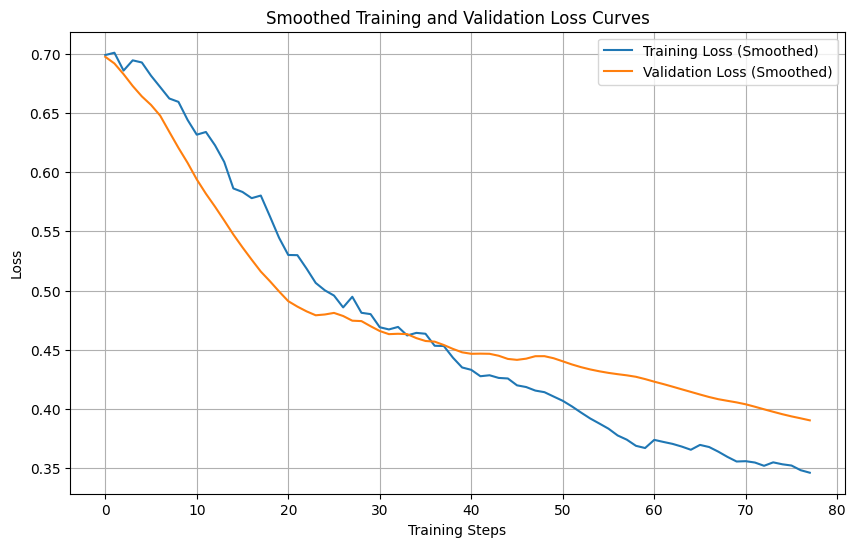

In [9]:
# Define best hyperparameters
best_hyperparams = {
    'lr': 5e-5,
    'batch_size': 16,
    'epochs': 2,
    'model_init': 'unfrozen'
}

# Call the function with best hyperparameters
train_and_evaluate_with_steps(
    model_init=best_hyperparams['model_init'],
    lr=best_hyperparams['lr'],
    batch_size=best_hyperparams['batch_size'],
    epochs=best_hyperparams['epochs'],
    train_seq=train_seq,
    train_mask=train_mask,
    train_y=train_y,
    val_seq=val_seq,
    val_mask=val_mask,
    val_y=val_y,
    window_size=100)

# BERT Fine-Tuned On PolitiFact (Human & LLM)

In [11]:
# Load data
train_human_df = pd.read_csv("/Applications/AI/msc_project/data/my_politifact_train.csv")
val_human_df = pd.read_csv("/Applications/AI/msc_project/data/my_politifact_validation.csv")
train_llm_df = pd.read_csv("/Applications/AI/msc_project/data/my_llm_fake_politifact_train.csv")
val_llm_df = pd.read_csv("/Applications/AI/msc_project/data/my_llm_fake_politifact_validation.csv")

# Combine Human & LLMFake datasets
filtered_train_llm_df = train_llm_df[['text', 'is_true']]
combined_train_df = pd.concat([train_human_df, filtered_train_llm_df], ignore_index=True)
filtered_val_llm_df = val_llm_df[['text', 'is_true']]
combined_val_df = pd.concat([val_human_df, filtered_val_llm_df], ignore_index=True)


# Pre-process data
train_untruncated_seq, train_seq, train_mask, train_y = pre_process_data(combined_train_df, tokenizer, max_len)
val_untruncated_seq, val_seq, val_mask, val_y = pre_process_data(combined_val_df, tokenizer, max_len)

/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be ren


 Epoch 1 / 2
Training Loss (last batch): 0.106
Validation Loss (last batch): 0.312

 Epoch 2 / 2
Training Loss (last batch): 0.053
Validation Loss (last batch): 0.365


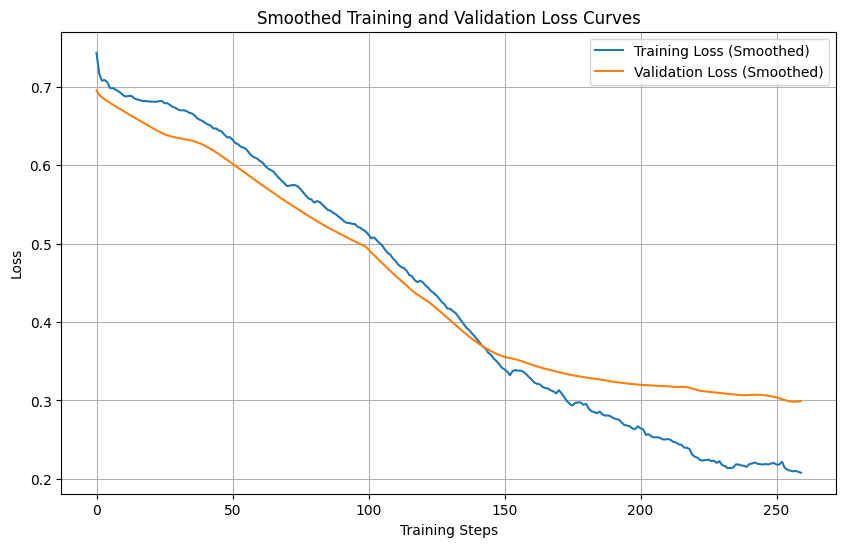

In [12]:
# Define best hyperparameters
best_hyperparams = {
    'lr': 1e-5,
    'batch_size': 16,
    'epochs': 2,
    'model_init': 'unfrozen'
}

# Call the function with best hyperparameters
train_and_evaluate_with_steps(
    model_init=best_hyperparams['model_init'],
    lr=best_hyperparams['lr'],
    batch_size=best_hyperparams['batch_size'],
    epochs=best_hyperparams['epochs'],
    train_seq=train_seq,
    train_mask=train_mask,
    train_y=train_y,
    val_seq=val_seq,
    val_mask=val_mask,
    val_y=val_y,
    window_size=100
)